In [151]:
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import lightgbm as lgb


In [152]:
#Read in Data
train = pd.read_csv("C:/Users/Aditya/Downloads/titanicext/train.csv", delimiter = ",")
test = pd.read_csv("C:/Users/Aditya/Downloads/titanicext/test.csv", delimiter = ",")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [153]:
#Data types and null values 
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

# Analyze by pivoting features
Analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

Pclass We observe significant correlation (>0.5) among Pclass=1 and Survived . We decide to include this feature in our model.
Sex We confirm the observation during problem definition that Sex=female had very high survival rate at 74% .
SibSp and Parch These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features .

In [154]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [155]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [156]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [157]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# Visualizing the data

Correlating numerical features

Observations:

Infants (Age <=4) had high survival rate.
Oldest passengers (Age = 80) survived.
Large number of 15-25 year olds did not survive.
Most passengers are in 15-35 age range.

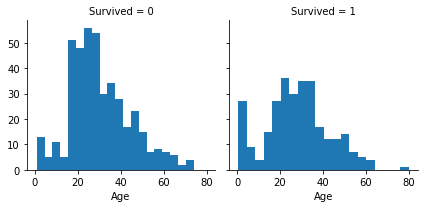

In [158]:
warnings.filterwarnings("ignore")
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Correlating numerical and ordinal features

Observations:

Pclass=3 had most passengers, however most did not survive. 
Infant passengers in Pclass=2 and Pclass=3 mostly survived. 
Most passengers in Pclass=1 survived. 
Pclass varies in terms of Age distribution of passengers.

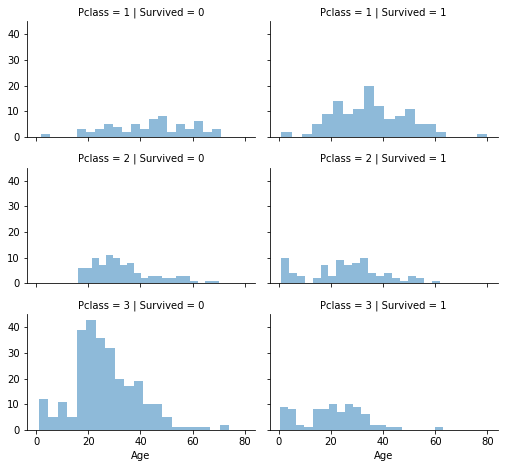

In [159]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

Correlating categorical features

Observations.

Female passengers had much better survival rate than males. 
Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. 
Ports of embarkation have varying survival rates for Pclass=3 and among male passengers.

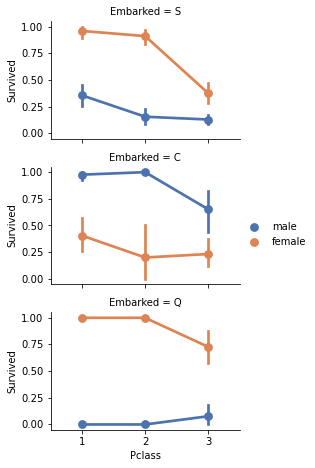

In [160]:
grid = sns.FacetGrid(train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Correlating categorical and numerical features

Observations.

Higher fare paying passengers had better survival. Fare ranges can be explored.
Port of embarkation correlates with survival rates.

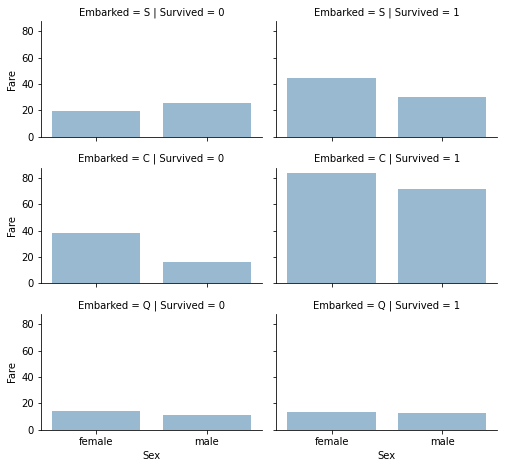

In [161]:
grid = sns.FacetGrid(train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# Wrangle data
Based on our assumptions and decisions we want to drop the Cabin  and Ticket features.

In [162]:
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

In [163]:
#Extract title from Name 
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train['Title'], train['Sex'])


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [164]:
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(test['Title'], test['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [165]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [166]:
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

# Feature Engineering
Creating new features by combining SibSp, Parch and creating Age bands and fare bands 

In [167]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)


test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [168]:
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()


test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

Impute missing values of Age and Fare with corresponding mean values of the same Pclass. 

In [169]:
# Age fillna with mean age for each class
age_map = train[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
train.Age = train.Age.fillna(train.Pclass.map(age_map['Age']))
Fare_map = train[['Fare', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
train.Fare = train.Fare.fillna(train.Pclass.map(Fare_map['Fare']))
age_map = test[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
test.Age = test.Age.fillna(test.Pclass.map(age_map['Age']))
Fare_map = test[['Fare', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
test.Fare = test.Fare.fillna(test.Pclass.map(Fare_map['Fare']))

catfeats_fillnamode = \
    ['Embarked']

train.loc[:, catfeats_fillnamode] = \
    train[catfeats_fillnamode].fillna(train[catfeats_fillnamode].mode().iloc[0])


test.loc[:, catfeats_fillnamode] = \
    test[catfeats_fillnamode].fillna(test[catfeats_fillnamode].mode().iloc[0])


In [170]:
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.336714
2,"(32.252, 48.168]",0.412844
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [171]:
train.loc[ train['Age'] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age'] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age'] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), 'Age'] = 3
train.loc[ train['Age'] > 64, 'Age'] 


test.loc[ test['Age'] <= 16, 'Age'] = 0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), 'Age'] = 1
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), 'Age'] = 2
test.loc[(test['Age'] > 48) & (test['Age'] <= 64), 'Age'] = 3
test.loc[ test['Age'] > 64, 'Age'] 


81    67.0
96    76.0
Name: Age, dtype: float64

In [172]:
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)



,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [173]:
train.loc[ train['Fare'] <= 7.91, 'Fare'] = 0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454), 'Fare'] = 1
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31.0), 'Fare']   = 2
train.loc[ train['Fare'] > 31.0, 'Fare'] = 3
train['Fare'] = train['Fare'].astype(int)


test.loc[ test['Fare'] <= 7.91, 'Fare'] = 0
test.loc[(test['Fare'] > 7.91) & (test['Fare'] <= 14.454), 'Fare'] = 1
test.loc[(test['Fare'] > 14.454) & (test['Fare'] <= 31.0), 'Fare']   = 2
test.loc[ test['Fare'] > 31.0, 'Fare'] = 3
test['Fare'] = test['Fare'].astype(int)



In [174]:
train = train.drop(['Name', 'SibSp','Parch','FamilySize','AgeBand','FareBand'], axis=1)

In [175]:
test = test.drop(['Name', 'SibSp','Parch','FamilySize'], axis=1)

Label encoding all object data types to build model.

In [176]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train['Title'] = train['Title'].map(title_mapping)
train['Title'] = train['Title'].fillna(0)
test['Title'] = test['Title'].map(title_mapping)
test['Title'] = test['Title'].fillna(0)



In [177]:
s = (train.dtypes == 'object')
r = (test.dtypes == 'object')
object_cols = list(s[s].index)
object_cols = list(r[r].index)
label_encoder = LabelEncoder()
for col in object_cols:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])

# Building model

In [180]:
X = train.drop(["PassengerId","Survived"],axis=1)
Y =  train["Survived"] 
X1 = test.drop(["PassengerId"],axis=1)

In [181]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
DTC = DecisionTreeClassifier()
DTC.fit(X_train,Y_train)
predTree = DTC.predict(X_test)
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(Y_test, predTree))

DecisionTrees's Accuracy:  0.7932960893854749


In [182]:
rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train)
predrfc = rfc.predict(X_test)
print("RFC's Accuracy: ", metrics.accuracy_score(Y_test, predrfc))

RFC's Accuracy:  0.8044692737430168


In [183]:
clf = XGBClassifier()
clf.fit(X_train,Y_train)
predxgb = clf.predict(X_test)
print("XGB's Accuracy: ", metrics.accuracy_score(Y_test, predxgb))

XGB's Accuracy:  0.8100558659217877


In [184]:
model_lgb = lgb.LGBMClassifier(boosting_type = 'dart',num_leaves = 32,max_depth = 10,colsample_bytree = 0.8,extra_trees = True,n_jobs = -1,random_state = 42)
model_lgb.fit(X_train,Y_train)
predlgb = model_lgb.predict(X_test)
print("LGB's Accuracy: ", metrics.accuracy_score(Y_test, predlgb))

LGB's Accuracy:  0.7821229050279329


In [185]:
GBoost = GradientBoostingClassifier()
GBoost.fit(X_train,Y_train)
predgb = GBoost.predict(X_test)
print("GB's Accuracy: ", metrics.accuracy_score(Y_test, predgb))

GB's Accuracy:  0.7877094972067039


In [186]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
ext = ExtraTreesClassifier(n_estimators = 1000,max_depth = 17,min_samples_split = 25,min_samples_leaf = 18,n_jobs = -1,random_state = 42)
ext.fit(X_train,Y_train)
predext = ext.predict(X_test)
print("ETC's Accuracy: ", metrics.accuracy_score(Y_test, predext))

ETC's Accuracy:  0.7597765363128491


In [187]:
Vclf = VotingClassifier(estimators=[('DT',DTC),('EXT',ext),('XGB' , clf)], voting='soft')
Vclf.fit(X_train,Y_train)
predVclf = Vclf.predict(X_test)
print("ETC's Accuracy: ", metrics.accuracy_score(Y_test, predVclf))

ETC's Accuracy:  0.776536312849162


In [188]:
from catboost import CatBoostClassifier
CBC = CatBoostClassifier()
CBC.fit(X_train,Y_train)
predCBC = CBC.predict(X_test)
print("CBC's Accuracy: ", metrics.accuracy_score(Y_test, predCBC))

Learning rate set to 0.008911
0:	learn: 0.6866187	total: 1.38s	remaining: 22m 55s
1:	learn: 0.6802849	total: 1.38s	remaining: 11m 28s
2:	learn: 0.6748348	total: 1.38s	remaining: 7m 39s
3:	learn: 0.6696539	total: 1.39s	remaining: 5m 45s
4:	learn: 0.6647887	total: 1.39s	remaining: 4m 36s
5:	learn: 0.6598678	total: 1.39s	remaining: 3m 50s
6:	learn: 0.6544471	total: 1.39s	remaining: 3m 17s
7:	learn: 0.6491375	total: 1.4s	remaining: 2m 53s
8:	learn: 0.6448288	total: 1.4s	remaining: 2m 34s
9:	learn: 0.6410590	total: 1.4s	remaining: 2m 18s
10:	learn: 0.6364986	total: 1.4s	remaining: 2m 6s
11:	learn: 0.6318218	total: 1.41s	remaining: 1m 55s
12:	learn: 0.6270087	total: 1.41s	remaining: 1m 46s
13:	learn: 0.6220215	total: 1.41s	remaining: 1m 39s
14:	learn: 0.6176444	total: 1.41s	remaining: 1m 32s
15:	learn: 0.6128986	total: 1.41s	remaining: 1m 26s
16:	learn: 0.6080231	total: 1.42s	remaining: 1m 21s
17:	learn: 0.6039149	total: 1.42s	remaining: 1m 17s
18:	learn: 0.5993225	total: 1.42s	remaining: 1m

In [190]:
DTC = DecisionTreeClassifier()
DTC.fit(X,Y)
predTree = DTC.predict(X1)
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predTree})
filename = "C:/Users/Aditya/Downloads/titanicext/predictionsDT.csv"
submission.to_csv(filename, index = False)

In [191]:
rfc = RandomForestClassifier()
rfc.fit(X,Y)
predRFC = rfc.predict(X1)
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predRFC})
filename = "C:/Users/Aditya/Downloads/titanicext/predictionsRFC.csv"
submission.to_csv(filename, index = False)

In [192]:
XGBclf = XGBClassifier()
XGBclf.fit(X,Y)
predxgb = XGBclf.predict(X1)
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predxgb})
filename = "C:/Users/Aditya/Downloads/titanicext/predictionsXGBC.csv"
submission.to_csv(filename, index = False)